Sparkify Project Workspace

Suppose, we are the data team of a popular digital music service similar to Spotify or Pandora. The users stream their favorite songs either using the free tier that place advertisements between songs or use the premium plan for which they pay a monthly fee without any advertisements between songs. Users can upgrade, downgrade or altogether cancel their services. The dataset given to us contains a log of the activities of each user on the service whether they are playing songs, logging out, upgrading their service or cancelling it. All this data contains key insights in keeping the users of the service happy. Our task in this project is to develop a model that predict which users are at risk. If we can identify users that are at risk to churn either by downgrading from premium or by cancelling their service, the business can offer them incentives and discounts potentially saving millions in revenues.

To tackle this project, we are given a subset of the dataset that contains a log of events mentioned below. The events include:

    Cancel
    Submit Downgrade
    Thumbs Down
    Home
    Downgrade
    Roll Advert
    Logout
    Save Settings
    Cancellation Conf...
    About
    Submit Registration
    Settings
    Login
    Register
    Add to Playlist
    Add Friend
    NextSong
    Thumbs Up
    Help
    Upgrade

To solve this problem, first we load the dataset into Apache Spark and delete any rows that have missing userIds or sessionIds. Then we calculate the below mentioned metrics from the given data for each user.

    average number of songs per session
    Total number of thumbs down
    Total number of thumbs up
    Total number of errors encountered
    Number of Add to Playlist events
    Number of Add Friends events
    Total number of songs played

The label which needs to be predicted is churn which is defined by a user who has performed either a "Submit Downgrade" event or "Cancellation Confirmation" event.

After the above features are calculated, we build the model using the following three algorithms:

    Logistic Regression
    Random Forest Classifier
    Gradient Boosting Trees

The dataset is split into training and testing sets. A machine learning pipeline is built in which we first convert each row into a single feature vector. Then data in each of the column is normalized and is fed into each of the above classifiers.
Metrics

The models are evaluated using the F1 score since we have a small number of churned users. F1 score is a better measure to use when there is an uneven class distribution. For our dataset, Gradient Boosted Tree Classifier gives the best F1 score. We also calculate the accuracy of each of the models but we base our decision of selecting a model based on the F1 score calculated.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, count, desc, explode, lit, min, max, split, stddev, udf, rand
from pyspark.sql.types import IntegerType
from pyspark.sql import types
from pyspark.ml import Pipeline, param
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import MinMaxScaler, CountVectorizer, IDF,Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

In [2]:
spark=SparkSession.builder.master('local').appName('Sparkify').getOrCreate()

In [3]:
df=spark.read.json('mini_sparkify_event_data.json')

In [4]:
kd=df.toPandas()

In [5]:
kd.shape

(286500, 18)

Checkpoint

In [6]:
kd.to_csv('df_file.csv', index=False)

In [7]:
pd.read_csv('df_file.csv')

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30.0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9.0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30.0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9.0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286495,NaN,Logged Out,NaN,NaN,41,NaN,NaN,paid,NaN,GET,Home,NaN,500,NaN,200,1543622240000,NaN,NaN
286496,NaN,Logged Out,NaN,NaN,42,NaN,NaN,paid,NaN,PUT,Login,NaN,500,NaN,307,1543622241000,NaN,NaN
286497,NaN,Logged In,Emilia,F,43,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,Home,1.538337e+12,500,NaN,200,1543622248000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011.0
286498,NaN,Logged In,Emilia,F,44,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,About,1.538337e+12,500,NaN,200,1543622398000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011.0


In [8]:
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [9]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [10]:
uid=df.toPandas()['userId'].unique().tolist()

In [11]:

for id in uid:
    if (id=='') | (id is None):
        print('id is Empty')

id is Empty


In [12]:
#Removing missing values from userId
check=df.dropna(subset=['userId'])
check=check.filter(check['userId']!='')

#Converting to dataframe
df_con= check.toPandas()

In [14]:
#Find Churned User(User who has already Downgrade or Cancel the subscription)

user=list(df_con[df_con['page']=='Submit Downgrade']['userId'].unique())
user.extend(list(df_con[df_con['page']=='Cancellation Confirmation']['userId'].unique()))
user=list(set(user))


In [38]:
# Taking Unique churned userId for better data understanding

ch_user=df_con['userId'].unique().tolist()
gen=[]
level =[]
for userId in ch_user:
    gen.append(df_con[df_con['userId']==userId]['gender'].iloc[0])
    level.append(df_con[df_con['userId']==userId]['level'].iloc[0])
gender = pd.DataFrame({'userId':ch_user, 'gender':gen})
gender['churn']=gender['userId'].apply(lambda x:1 if x in user else 0)
leval = pd.DataFrame({'userId': ch_user, 'level': level})
leval['churn'] = gender['userId'].apply(lambda x: 1 if x in user else 0)

In [ ]:
gender

In [ ]:
leval

In [24]:
gender.gender.value_counts()

M    121
F    104
Name: gender, dtype: int64

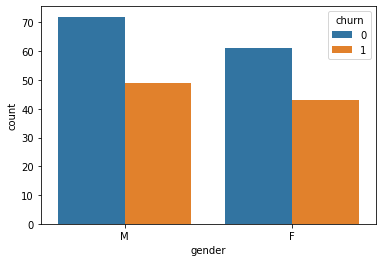

In [29]:
sns.countplot(x='gender', hue='churn', data=gender)

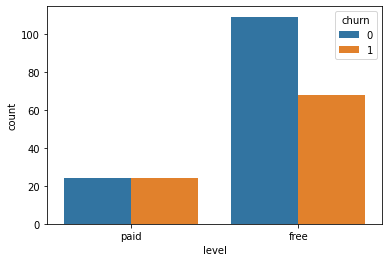

In [39]:
sns.countplot(x='level', hue='churn', data=leval)

In [41]:
check.createOrReplaceTempView('table_spark')

Visualize session history

In [46]:
sessions=spark.sql('SELECT userId, avg(count) as average from (SELECT userId, count(*) as count FROM table_spark group by sessionId, userId) group by userId')

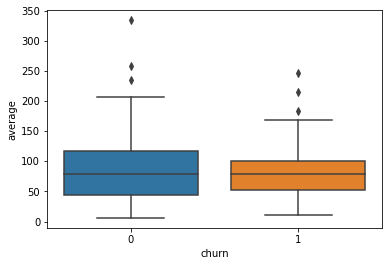

In [48]:
df_sessions=sessions.toPandas()
df_sessions['churn']= df_sessions['userId'].apply(lambda x: 1 if x in user else 0)
sns.boxplot(x='churn', y='average', data=df_sessions)

Visualize popularity (thumbs up and thumbs down)

In [59]:
thumbs_down= spark.sql("SELECT userId, count(*) as count_thumbs_down FROM table_spark where page = 'Thumbs Down' group by userId")

In [60]:
thumbs_up = spark.sql("SELECT userId, count(*) as count_thumbs_up FROM table_spark where page = 'Thumbs Up' group by userId")

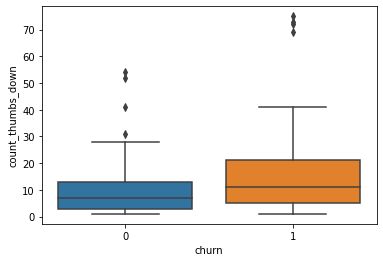

In [61]:
df_thumbs_down=thumbs_down.toPandas()
df_thumbs_down['churn']=df_thumbs_down['userId'].apply(lambda x: 1 if x in user else 0)
sns.boxplot(x='churn', y= 'count_thumbs_down', data=df_thumbs_down)

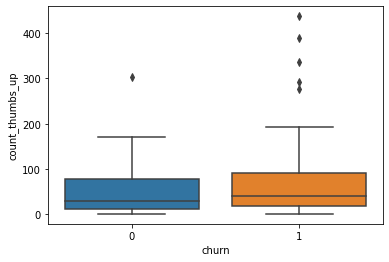

In [62]:
df_thumbs_up=thumbs_up.toPandas()
df_thumbs_up['churn']=df_thumbs_up['userId'].apply(lambda x: 1 if x in user else 0)
sns.boxplot(x='churn', y= 'count_thumbs_up', data=df_thumbs_up)

Visualize Add Friends

In [64]:
add_friend=spark.sql("SELECT userId, count(*) as count_add_friend FROM table_spark where page = 'Add Friend' group by userId")

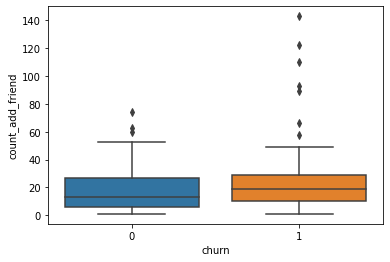

In [67]:
df_add_friend=add_friend.toPandas()
df_add_friend['churn']= df_add_friend['userId'].apply(lambda x:1 if x in user else 0)
sns.boxplot(x='churn', y='count_add_friend', data=df_add_friend)

In [80]:
# Visualize songs added to playlist
playlist_songs = spark.sql("SELECT userId, count(*) as playlist_count FROM table_spark where page = 'Add to Playlist' group by userId")

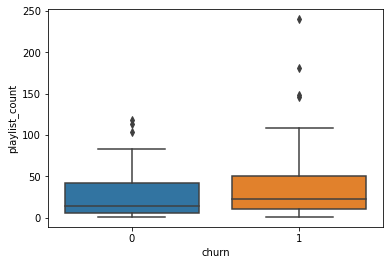

In [82]:
df_playlist_songs=playlist_songs.toPandas()
df_playlist_songs['churn']= df_playlist_songs['userId'].apply(lambda x:1 if x in user else 0)
sns.boxplot(x='churn', y='playlist_count',data=df_playlist_songs)

In [74]:
total_songs=spark.sql("SELECT userId, count(*) as count_total_songs FROM table_spark group by userId")

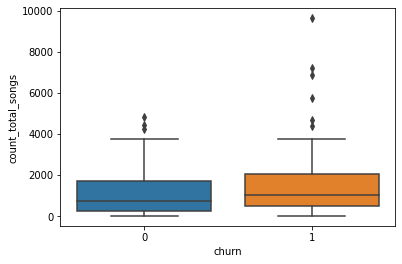

In [76]:
df_total_songs=total_songs.toPandas()
df_total_songs['churn'] = df_total_songs['userId'].apply(lambda x: 1 if x in user else 0)
sns.boxplot(x='churn', y='count_total_songs', data=df_total_songs)

In [78]:
# Visualize error page

total_error= spark.sql("SELECT userId, count(*) as count_error FROM table_spark where page = 'Error' group by userId")

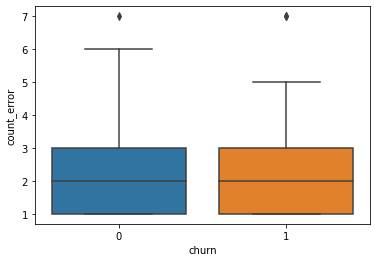

In [79]:
df_total_error=total_error.toPandas()
df_total_error['churn']=df_total_error['userId'].apply(lambda x:1 if x in user else 0)
sns.boxplot(x='churn', y='count_error', data= df_total_error)

In [84]:
#Flag event for downgrade
flag=udf(lambda x: 1 if (x=='Submit Downgrade' or x=='Cancellation Confirmation') else 0, IntegerType())

In [85]:
flag_event = spark.sql("SELECT userId, CASE when page = 'Submit Downgrade' or page = 'Cancellation Confirmation' THEN 1 END as churn from table_spark")

In [86]:
flag_event.createOrReplaceTempView('churn_table')
downgrade_event= spark.sql("SELECT * FROM churn_table where churn is not null")
downgrade_event.createOrReplaceTempView('churn_user')

In [88]:
spark.sql("SELECT * from churn_user").show()

+------+-----+
|userId|churn|
+------+-----+
|   131|    1|
|    38|    1|
|   141|    1|
|    18|    1|
|    30|    1|
|    20|    1|
|    32|    1|
|    12|    1|
|    11|    1|
|    61|    1|
|    81|    1|
|   125|    1|
|    85|    1|
|   140|    1|
|   105|    1|
|    17|    1|
|    35|    1|
|   143|    1|
|    54|    1|
|    77|    1|
+------+-----+
only showing top 20 rows



In [101]:
# Joining into single dataset

temp1 = thumbs_down.join(thumbs_up, thumbs_down.userId == thumbs_up.userId).drop(thumbs_up.userId)
temp2 = temp1.join(total_error, total_error.userId == temp1.userId).drop(total_error.userId)
temp3 = temp2.join(playlist_songs, playlist_songs.userId == temp2.userId).drop(playlist_songs.userId)
temp4 = temp3.join(add_friend, add_friend.userId == temp3.userId).drop(add_friend.userId)
temp5 = temp4.join(total_songs, total_songs.userId == temp4.userId).drop(total_songs.userId)
temp6 = temp5.join(sessions, sessions.userId == temp5.userId).drop(sessions.userId)
temp7 = temp6.join(downgrade_event, downgrade_event.userId == temp6.userId, "left_outer").drop(downgrade_event.userId)

In [102]:
temp7.createOrReplaceTempView('temp_table')
processed_df = spark.sql("SELECT userId, count_thumbs_down, count_thumbs_up, count_error,  playlist_count, count_add_friend, count_total_songs, average, CASE when churn is null then 0 else 1 END as label from temp_table ")

In [103]:
train, test =processed_df.randomSplit([0.9, 0.1], seed = 42)

In [117]:
input_cols = ['count_thumbs_down', 'count_thumbs_up', 'count_error', 'playlist_count', 'count_add_friend', 'count_total_songs', 'average']

assembler = VectorAssembler(inputCols = input_cols, outputCol= "features")
scalar = MinMaxScaler(inputCol = "features", outputCol = "scaled_features")

In [120]:
lr = LogisticRegression(labelCol = "label", featuresCol = "scaled_features", maxIter= 10, regParam=0.0, elasticNetParam = 0)

pipeline_lr = Pipeline(stages= [assembler, scalar, lr])

paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.0, 0.1]).build()

crossval_lr = CrossValidator(estimator=pipeline_lr, 
                             estimatorParamMaps= paramGrid,
                             evaluator = MulticlassClassificationEvaluator(),
                             numFolds=3)

cvModel_lr = crossval_lr.fit(train)
cvModel_lr.avgMetrics

result_lr = cvModel_lr.transform(test)
print("Accuracy for Logistic Regression Model is:", result_lr.filter(result_lr.label == result_lr.prediction).count()/result_lr.count())

evaluator = MulticlassClassificationEvaluator(metricName = 'f1')

score = evaluator.evaluate(result_lr)
print('F1 score for Logistic Regression model is:', score)


Accuracy for Logistic Regression Model is: 0.375
F1 score for Logistic Regression model is: 0.40476190476190477


Accuracy for Logistic Regression Model is: 0.375
F1 score for Logistic Regression model is: 0.40476190476190477


In [121]:
print('The best performing regualrization parameter is:', cvModel_lr.bestModel.stages[-1]._java_obj.parent().getRegParam())

The best performing regualrization parameter is: 0.1


In [125]:
rf = RandomForestClassifier(labelCol='label', featuresCol = 'scaled_features', numTrees=10)
pipeline_rf = Pipeline(stages=[assembler, scalar, rf])

paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [5,10]).build()

crossval_rf = CrossValidator(estimator= pipeline_rf, 
                             estimatorParamMaps=paramGrid,
                             evaluator=MulticlassClassificationEvaluator(),
                             numFolds=3)

cvModel_rf = crossval_rf.fit(train)
cvModel_rf.avgMetrics
result_rf = cvModel_rf.transform(test)

print('Accuracy for Random Forest Model is:', result_rf.filter(result_rf.label==result_rf.prediction).count()/result_rf.count())

evaluator = MulticlassClassificationEvaluator(metricName='f1')
rfc_score= evaluator.evaluate(result_rf)

print("F1 score for Random Forest Model is:", rfc_score)

Accuracy for Random Forest Model is: 0.375
F1 score for Random Forest Model is: 0.3253968253968254


In [126]:
print("The best value for the number of trees is:", cvModel_rf.bestModel.stages[-1]._java_obj.parent().getNumTrees())

The best value for the number of trees is: 10


In [135]:
gbt = GBTClassifier(labelCol='label', featuresCol='scaled_features', maxIter=10)
pipeline_gbt=Pipeline(stages= [assembler, scalar, gbt])

paramGrid =ParamGridBuilder().addGrid(gbt.maxIter, [5,10]).build()

crossval_gbt = CrossValidator(estimator=pipeline_gbt, 
                             estimatorParamMaps=paramGrid,
                             evaluator=MulticlassClassificationEvaluator(),
                             numFolds=3, 
                             collectSubModels=True)
cvModel_gbt =crossval_gbt.fit(train)
cvModel_gbt.avgMetrics
result_gbt = cvModel_gbt.transform(test)

print("Accuracy for Gradient Boosting Tree Model is:", result_gbt.filter(result_gbt.label==result_gbt.prediction).count()/result_gbt.count())

evaluator = MulticlassClassificationEvaluator(metricName= 'f1')
gbt_score = evaluator.evaluate(result_gbt)

print('F1 score for Gradient Boosting Tree classifier is:', gbt_score)

Accuracy for Gradient Boosting Tree Model is: 0.5
F1 score for Gradient Boosting Tree classifier is: 0.5333333333333333


In [136]:
print("The best Value for maximum number of interations is:", cvModel_gbt.bestModel.stages[-1]._java_obj.parent().getMaxIter())

The best Value for maximum number of interations is: 5


In [156]:
class CrossValidatorVerbose(CrossValidator):

    def _fit(self, dataset):
        est = self.getOrDefault(self.estimator)
        epm = self.getOrDefault(self.estimatorParamMaps)
        numModels = len(epm)

        eva = self.getOrDefault(self.evaluator)
        metricName = eva.getMetricName()

        nFolds = self.getOrDefault(self.numFolds)
        seed = self.getOrDefault(self.seed)
        h = 1.0 / nFolds

        randCol = self.uid + "_rand"
        df = dataset.select("*", rand(seed).alias(randCol))
        metrics = [0.0] * numModels

        for i in range(nFolds):
            foldNum = i + 1
            print("Comparing models on fold %d" % foldNum)

            validateLB = i * h
            validateUB = (i + 1) * h
            condition = (df[randCol] >= validateLB) & (df[randCol] < validateUB)
            validation = df.filter(condition)
            train = df.filter(~condition)

            for j in range(numModels):
                paramMap = epm[j]
                model = est.fit(train, paramMap)
                # TODO: duplicate evaluator to take extra params from input
                metric = eva.evaluate(model.transform(validation, paramMap))
                metrics[j] += metric

                avgSoFar = metrics[j] / foldNum
                print("params: %s\t%s: %f\tavg so far: %f" % (
                    {param.name: val for (param, val) in paramMap.items()},
                    metricName, metric, avgSoFar))

        if eva.isLargerBetter():
            bestIndex = np.argmax(metrics)
        else:
            bestIndex = np.argmin(metrics)

        bestParams = epm[bestIndex]
        bestModel = est.fit(dataset, bestParams)
        avgMetrics = [m / nFolds for m in metrics]
        bestAvg = avgMetrics[bestIndex]
        print("Best model:\nparams: %s\t%s: %f" % (
            {param.name: val for (param, val) in bestParams.items()},
            metricName, bestAvg))

        return self._copyValues(CrossValidatorModel(bestModel, avgMetrics))

In [157]:
model = CrossValidatorVerbose(estimator=pipeline_gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
model.fit(train)

Comparing models on fold 1
params: {'maxIter': 5}	f1: 0.598997	avg so far: 0.598997
params: {'maxIter': 10}	f1: 0.622879	avg so far: 0.622879
Comparing models on fold 2
params: {'maxIter': 5}	f1: 0.536356	avg so far: 0.567677
params: {'maxIter': 10}	f1: 0.592876	avg so far: 0.607877
Comparing models on fold 3
params: {'maxIter': 5}	f1: 0.600000	avg so far: 0.578451
params: {'maxIter': 10}	f1: 0.574734	avg so far: 0.596830
Best model:
params: {'maxIter': 10}	f1: 0.596830


CrossValidatorModel_b89401942a1b